In [133]:
import pandas as pd
import scipy
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils.generators import UserGenerator

In [2]:
%matplotlib inline

In [3]:
# A simple generator to simulate userdata
ug = UserGenerator(column_label='Clickthrough Rate')

In [4]:
# creating a dataframe prelabeled for AB testing
# the outcome will contain 2 groups, A with a success rate of 12% B with a success rate of 10 % . 
df = ug.generate_ab_split_df(nr_of_users=4000,positive_ratio_A=0.12, positive_ratio_B=0.1, nr_of_days=5,AB_user_ratio=0.5)

In [5]:
# looking at the data
df.head(2)

,user_id,Clickthrough Rate,datetime,group
0,uid_4094,0,2020-01-01 18:57:39,A
1,uid_4095,0,2020-01-03 11:14:06,A


In [7]:
# creating a label to make a more visual plot
df['hour'] =  df.datetime.dt.day.astype(str) + df.datetime.dt.hour.astype(str)

[Text(0, 0.5, 'Häufigkeit'), Text(0.5, 0, 'Clickthrough Rate')]

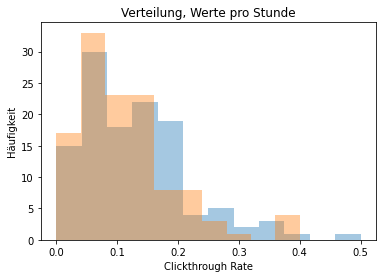

In [9]:
# Plot the hour grouped mean clickthrogh distribution
ax = sns.distplot(df.loc[df.group == 'A'].groupby(['hour'])['Clickthrough Rate'].mean(), kde=False)
ax = sns.distplot(df.loc[df.group == 'B'].groupby(['hour'])['Clickthrough Rate'].mean(), kde=False)
ax.set_title('Verteilung, Werte pro Stunde')
ax.set(xlabel='Clickthrough Rate', ylabel='Häufigkeit')

In [ ]:
# NOT THE RIGHT WAY !
# simplest approaches with wrong / questionable assumptions.
# let's assume normal distributed means. 
# all we need are the means and standard deviations 

# compare with Unpaired t- test.  Unpaired because the two datasets are not paired up.
df.groupby('group')['Clickthrough Rate'].mean()
df.groupby('group')['Clickthrough Rate'].std()

In [41]:
group_A_modelassumptions = np.random.normal(loc = df.loc[df.group == 'A']['Clickthrough Rate'].mean()
                 , scale=df.loc[df.group == 'A']['Clickthrough Rate'].std()
                 , size =100 )

group_B_modelassumptions = np.random.normal(loc = df.loc[df.group == 'B']['Clickthrough Rate'].mean()
                 , scale=df.loc[df.group == 'A']['Clickthrough Rate'].std()
                 , size =100 )

[Text(0, 0.5, 'Häufigkeit'), Text(0.5, 0, 'Clickthrough Rate')]

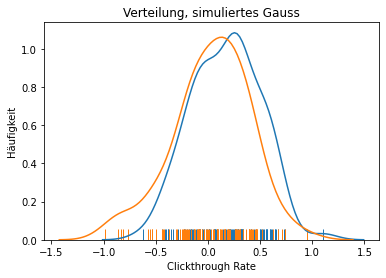

In [158]:
# Plot what the model assumes is happening :
ax = sns.distplot(group_A_modelassumptions, kde=True, hist=False, rug=True)
ax = sns.distplot(group_B_modelassumptions, kde=True, hist=False, rug= True)
ax.set_title('Verteilung, simuliertes Gauss')
ax.set(xlabel='Clickthrough Rate', ylabel='Häufigkeit')

In [66]:
t_statistic, p_value = scipy.stats.ttest_ind(df.loc[df.group=='A']['Clickthrough Rate'],df.loc[df.group=='B']['Clickthrough Rate'] )

In [67]:
# t statistic
t_statistic

1.8323762880905794

In [68]:
# p value
p_value #  this is above 0.05   so we assume there is no difference between A and B

0.0669697179949313

In [69]:
# proper assumptions Binomial Distribution
# Fischers Exact test 

In [114]:
# 2X2 contingency table
def create_contingency(df):
    """
    create a contingency table
    """
    contingency = {'A': {'0': df.loc[df.group=='A'].shape[0] - df.loc[df.group=='A']['Clickthrough Rate'].sum() 
                     
                     ,'1': df.loc[df.group=='A']['Clickthrough Rate'].sum() 
                    }
               
               ,'B': {'0': df.loc[df.group=='B'].shape[0] - df.loc[df.group=='B']['Clickthrough Rate'].sum() 
                     
                     ,'1': df.loc[df.group=='B']['Clickthrough Rate'].sum() 
                    }
              }
    return pd.DataFrame.from_dict(contingency)



contingency_table = create_contingency(df)

In [115]:
contingency_table

,A,B
0,1751,1788
1,249,212


In [83]:
oddsratio, pvalue = scipy.stats.fisher_exact(table=contingency_table)

In [85]:
pvalue

0.07456985796196819

Under the assumption that a 20% lift is significant,  
lets test how many sample we need to reliably get the right answer

In [170]:


def simulate_ABtest(data_generator, nr_of_users,  lift ):
    """
    takes the 
    
    sample generator: UserGenerator OBJECT, 
    nr_of_users INT : number of requested users and 
    lift FLOAT : requested lift
    
    returns:
    p values pair
    
    calculate the p values for the Gaussian (wrong) and Binomial (right) distribution
    
    """
    dat = data_generator.generate_ab_split_df(nr_of_users=nr_of_users
                                              ,positive_ratio_A=0.1
                                              ,positive_ratio_B=0.1 + lift
                                              ,nr_of_days=5 # not relevant here
                                              ,AB_user_ratio=0.5 ) # euqual sized groups )
    
    t_statistic, p_value_norm = scipy.stats.ttest_ind(dat.loc[dat.group=='A']['Clickthrough Rate'],
                                                 dat.loc[dat.group=='B']['Clickthrough Rate'] )
                                                                                        
    contingency = create_contingency(dat)
    ddsratio, p_value_binom = scipy.stats.fisher_exact(table=contingency)
    
    return p_value_norm, p_value_binom

In [171]:
%time simulate_ABtest(ug, 100,0.1)

CPU times: user 16.5 ms, sys: 2 µs, total: 16.5 ms
Wall time: 14.4 ms


(0.40593079676003696, 0.5766469929158452)

In [175]:
# simulate sensitivitiy to sample size

sample_sizes = [n*100 for n in range(1,100) ]

p_values_samples_sizes = {}


for samle_size in sample_sizes:
    _, p_val = simulate_ABtest(ug, samle_size ,0.02)
    p_values_samples_sizes[samle_size] = p_val


In [176]:
simulate_ABtest(ug, 10000 ,0.02)

(0.036624428240684764, 0.039569651447312476)

In [189]:
dat = pd.DataFrame.from_dict({'pval':p_values_samples_sizes}, orient='columns')

In [192]:
dat.reset_index(inplace=True)

In [194]:
dat['significant'] = 1
dat.loc[dat.pval < 0.05,'significant'] = 0

[Text(0, 0.5, 'p-Value'), Text(0.5, 0, 'Zahl der Proben')]

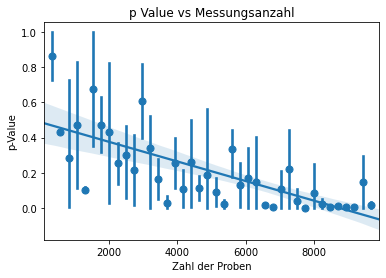

In [204]:
ax = sns.regplot(x='index',y='pval', data=dat, x_bins=40)
ax.set_title("p Value vs Messungsanzahl")
ax.set(xlabel='Zahl der Proben', ylabel='p-Value')

In [111]:
simulate_ABtest(ug, 200, .2)

(8.115456395285687e-05, 0.07456985796196819)

In [156]:
# Add also the dimension of lift to test

lifts = np.linspace(0,.3,num=200) # between 0 and 30% increase
users = [n*100 for n in range(1, 100)]  # 100 to 10000 users
repetitions = 5

count = 0

p_val_norm = pd.DataFrame()
p_val_binom = pd.DataFrame()


for lift in tqdm(lifts):
    for user in users:
        for repetition in range(repetitions):
            count +=1
            
            pn, pb = simulate_ABtest(ug, user,lift)
            
#            p_val_norm_dict[f'{lift}-{user}-{repetition}'] = pn
#            p_val_binom_dict[f'{lift}-{user}-{repetition}'] = pb
            
            
            p_val_norm = p_val_norm.append(pd.Series({'lift':lift, 'users':user,'rep': repetition, 'pval':pn}),ignore_index=True )
            p_val_binom = p_val_norm.append(pd.Series({'lift':lift, 'users':user,'rep':repetition, 'pval':pb}),ignore_index=True )

100%|██████████| 200/200 [1:19:50<00:00, 23.95s/it]


In [157]:
p_val_binom.to_csv('pvalues_binom_table.csv')
p_val_norm.to_csv('pvalues_norm_table.csv')

In [148]:
p_val_norm.groupby('lift')['pval'].std()

lift
0.000000    0.286347
0.001508    0.267419
0.003015    0.282347
0.004523    0.293667
0.006030    0.276073
              ...   
0.293970    0.297401
0.295477    0.275073
0.296985    0.271366
0.298492    0.287270
0.300000    0.287207
Name: pval, Length: 200, dtype: float64

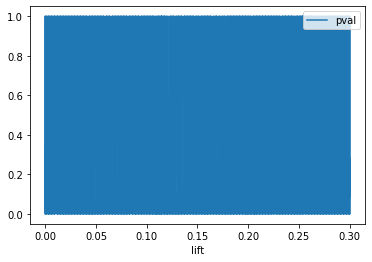

In [154]:
p_val_norm.plot(kind='line',x='lift', y='pval')

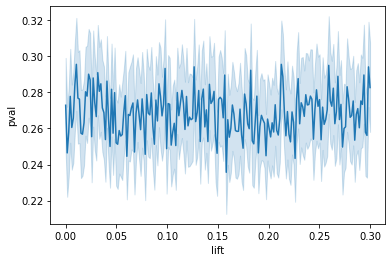

In [155]:
sns.lineplot(x="lift", y="pval", data=p_val_norm)

In [138]:
p_val_binom.loc['']

,lift,pval,rep,users
0,0.0,0.029176,0.0,100.0
1,0.0,0.206349,1.0,100.0
2,0.0,1.000000,2.0,100.0
3,0.0,0.429601,3.0,100.0
4,0.0,0.021674,4.0,100.0
...,...,...,...,...
98996,0.3,0.029176,1.0,9900.0
98997,0.3,0.466447,2.0,9900.0
98998,0.3,0.136334,3.0,9900.0
98999,0.3,0.279874,4.0,9900.0
